In [1]:
import sys
sys.path.append('/home/enes/bim/')# you should have this package on the sys.path

from utils import InferEta, Neutrality_Tests, Colless, intersect_with_weights
from Bimbalance import bSFS, bTree, PConst,Pnkb

In [2]:
import tskit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import seaborn as sns
from tqdm.notebook import tqdm

import sys, os
sys.path = ['/home/enes/.conda/envs/gene/lib/python3.8/site-packages'] + sys.path
import pyslim
import numpy as np
import msprime as msp
from IPython.display import SVG, display

plt.style.use('default')

In [4]:
import jax.numpy as jnp
from jax import lax
import jax
from jax.scipy.special import gammaln as LG
jax.config.update("jax_enable_x64", True)

from gmpy2 import mpq
import gmpy2
gmpy2.get_context().precision = 1000

from functools import partial, lru_cache
from dataclasses import dataclass
import scipy
import tskit
import re
import numpy as np

from utils import tree_to_splits

@lru_cache(None)
def _nc2(N):
    return N * (N - 1) // 2

@lru_cache(None)
def _A(N):
    '''
    returns A_jk calculated as eq6 @ Polanski

    Parameters
    ----------
    N : int
        sample size.

    Returns
    -------
    A : ndarray

    '''
    A = np.zeros([N - 1, N - 1], dtype=object)
    for k in range(2, N + 1):
        for j in range(k, N + 1):
            A[k - 2, j - 2] = np.prod([mpq(_nc2(ell), _nc2(ell) - _nc2(j)) for ell in range(k, N + 1) if ell != j])
    A[N - 2, N - 2] = 1
    return A

def get_BETmm(eta, N):
    j = np.arange(2, N + 1)
    k = np.arange(2, N + 1)
    A = _A(N)
    B = (A * (j * (j - 1))[None, :] / (k - 1)[:, None])
    ETmm = [eta.exp_integral(j * (j - 1) // 2) for j in range(2, N + 1)]
    BETmm = B @ ETmm        
    return BETmm.astype('float')

def get_pmf(n, beta):
    beta = 2*(jnp.exp(beta)-1)
    k = jnp.arange(n+1)
    norm = jnp.where(beta>1, np.log(-2**(-2 - 2*beta)*(np.sqrt(np.pi))/(np.sin((beta+n)*np.pi)))+
                     LG(-0.5-beta)+LG(1+beta)-LG(-1-2*beta-n)-LG(1+n), 0)

    if np.isnan(norm):
        norm = jnp.where(beta>1, np.log(2**(-2 - 2*beta)*(np.sqrt(np.pi))/(np.sin((beta+n)*np.pi)))+
                         LG(-0.5-beta)+LG(1+beta)-LG(-1-2*beta-n)-LG(1+n), 0)

    fx = LG(k+beta+1) + LG(n-k+beta+1) - LG(k+1) - LG(n-k+1)
    fx = jnp.exp(fx - norm)
    fx = fx[1:-1]
    fx = fx/fx.sum()
    return fx

def Pnkb(N, beta):
       
    P = np.zeros((N, N))

    for n in range(1, N+1):
        P[n-1, :(n-1)] = 2*get_pmf(n, beta)
    
    P = P - jnp.identity(N)
    
    State = jnp.zeros(N)
    State = jax.ops.index_update(State, jax.ops.index[N-1], 1)
    lins = jnp.arange(N)
    State = State.reshape(1, N)
       
    mean_ling = jnp.concatenate([jnp.zeros(N - 1), jnp.ones(1)])
    def loop_body(mean_ling_im1, i):
        State = i * mean_ling_im1
        probs = lins * State # weight the probs with size (Durett forward split)
        probs /= jnp.sum(probs)
        State += jnp.matmul(probs, P)      
        State = jax.ops.index_update(State, jax.ops.index[-i], 0)
        return (State / (i + 1),) * 2

    _, mean_ling = lax.scan(loop_body, mean_ling, jnp.arange(1, N))
    
    return mean_ling[:,:-1]

In [5]:
eta = PConst(a = [1.], t = [0.])
N = 250
BETmm = get_BETmm(eta, N)

def Ebl(beta, pmf):
    pnkb = Pnkb(N, beta)
    model = jnp.matmul(pnkb.T, BETmm)
    return model

In [6]:
nt = Neutrality_Tests(N)

In [7]:
beta = 0.
def Ef(i):
    x = np.arange(1, i)
    fx = np.abs(i-2*x)
    p = get_pmf(i, beta)
    return (fx*p).sum()   
Ef(10)

DeviceArray(4.44444444, dtype=float64)

In [13]:
get_pmf(10, 0.)

DeviceArray([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
             0.11111111, 0.11111111, 0.11111111, 0.11111111],            dtype=float64)

In [192]:
def EIc(n, beta, pmf):
    
    def Ef(i):
        x = np.arange(1, i)
        fx = np.abs(i-2*x)
        p = get_pmf(i, beta)
        return (fx*p).sum()   
    
    pnkb = Pnkb(n, beta)
    t = Ef(n)
    
    for k in range(2, n-1):
        i = np.arange(2, n-k+3)
        t += np.sum(((i-1)/(n-k))*pnkb[k-2, i-2]*np.array([Ef(_) for _ in i]))

    return t/((n-1)*(n-2)/2)

fA

In [196]:
betas = np.linspace(-8, 5, 51)

dfcorr = []

for beta in betas:   
    sfs = Ebl(beta, fa)
    
    cur = {'bsfs': beta,
           'TajD': nt.TajD(sfs, False), 'FulD': nt.FulD(sfs, False), 'FayH': nt.FayH(sfs, False),
           'ZngE': nt.ZngE(sfs, False)}
    dfcorr.append(cur)

dfcorr = pd.DataFrame(dfcorr)

<ipython-input-103-a254e11a5c4d>:58: RuntimeWarning: invalid value encountered in log
  norm = jnp.where(beta>1, np.log(-2**(-2 - 2*beta)*(np.sqrt(np.pi))/(np.sin((beta+n)*np.pi)))+


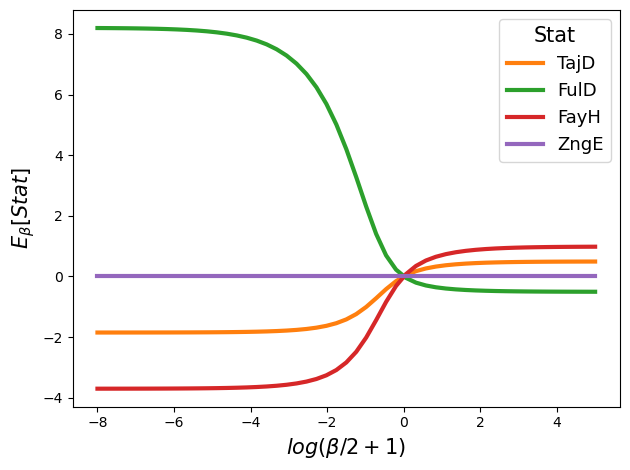

In [197]:
plt.style.use('default')
plt.plot(0, 0)
for stat in dfcorr.columns[1:]:
    x = dfcorr['bsfs']
    plt.plot(x, dfcorr[stat], linewidth = 3, label = stat)
leg = plt.legend(ncol = 1, prop={'size': 13})
leg.set_title('Stat',prop={'size':15})

plt.xlabel(r'$log(\beta/2+1)$', size = 15)
plt.ylabel(r'$E_{\beta}[Stat]$', size = 15)
plt.tight_layout()
plt.savefig('plots/betasfs_rls.jpg', dpi = 300)

In [198]:
betas = np.linspace(-8, 5, 21)
EIcs = []

for N in [50, 100, 150, 200, 250]:
    for beta in betas:
        cur = {'N': N,
               'bsfs': beta,
               'Colless': EIc(N, beta, fa)}
        EIcs.append(cur)

<ipython-input-103-a254e11a5c4d>:58: RuntimeWarning: invalid value encountered in log
  norm = jnp.where(beta>1, np.log(-2**(-2 - 2*beta)*(np.sqrt(np.pi))/(np.sin((beta+n)*np.pi)))+


In [199]:
EIcs = pd.DataFrame(EIcs)
EIcs['Colless'] = EIcs['Colless'].astype('float')

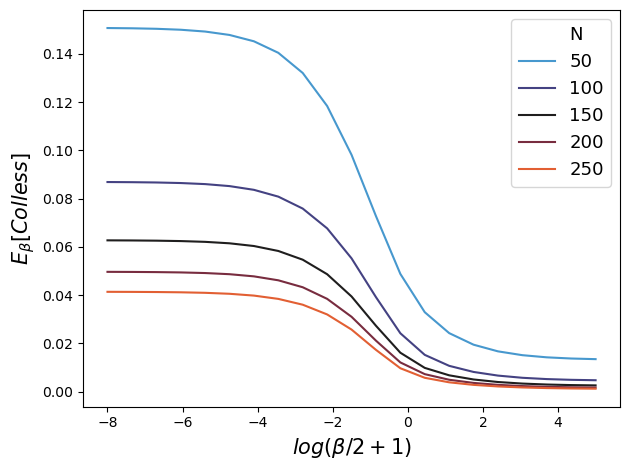

In [200]:
sns.lineplot('bsfs', 'Colless', hue = 'N', data = EIcs, palette=sns.color_palette("icefire", n_colors=5))
plt.xlabel(r'$log(\beta/2+1)$', size = 15)
plt.ylabel(r'$E_{\beta}[Colless]$', size = 15)
leg = plt.legend(ncol = 1, prop={'size': 13})
plt.tight_layout()
plt.savefig('plots/betasfs_colless.jpg', dpi = 300)

Taj D

In [201]:
betas = np.linspace(-8, 5, 51)

tajcor = []

for N in [50, 100, 150, 200, 250]:
    BETmm = get_BETmm(eta, N)

    def Ebl(beta, pmf):
        pnkb = Pnkb(N, beta)
        model = jnp.matmul(pnkb.T, BETmm)
        return model
    
    nt = Neutrality_Tests(N)
    for beta in betas:   
        sfs = Ebl(beta, fa)

        cur = {'N': N,
               'bsfs': beta,
               'TajD': nt.TajD(sfs, False)}
        tajcor.append(cur)

tajcor = pd.DataFrame(tajcor)

<ipython-input-103-a254e11a5c4d>:58: RuntimeWarning: invalid value encountered in log
  norm = jnp.where(beta>1, np.log(-2**(-2 - 2*beta)*(np.sqrt(np.pi))/(np.sin((beta+n)*np.pi)))+


In [202]:
tajcor['TajD'] = tajcor['TajD'].astype('float')

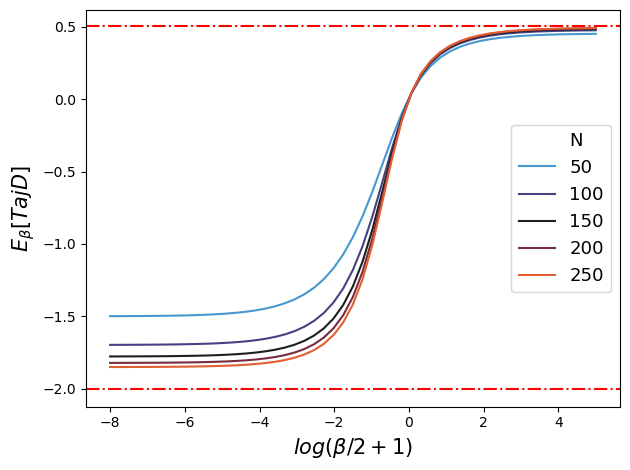

In [204]:
sns.lineplot('bsfs', 'TajD', hue = 'N', data = tajcor, palette=sns.color_palette("icefire", n_colors=5))
plt.xlabel(r'$log(\beta/2+1)$', size = 15)
plt.ylabel(r'$E_{\beta}[TajD]$', size = 15)
leg = plt.legend(ncol = 1, prop={'size': 13})
plt.axhline(-2, color = 'red', linestyle = '-.')
plt.axhline(0.50372, color = 'red', linestyle = '-.')
plt.tight_layout()
plt.savefig('plots/betasfs_tajd.jpg', dpi = 300)

Topological Variance

In [8]:
def H(n):
    i = np.arange(1,n+1)
    return np.sum(1/i)

In [9]:
eta = PConst(a = [1.], t = [0.]) # constant population sizes
N = 100
hn = H(N-1)
BETmm = get_BETmm(eta, N)
nt = Neutrality_Tests(N)

def Ebl(beta, pmf):
    pnkb = Pnkb(N, beta)
    model = jnp.matmul(pnkb.T, BETmm)
    return model

In [10]:
hn = H(N-1)
betas = np.linspace(-8, 5, 11)

varrel = []
for beta in betas:
    pnkb = Pnkb(N, beta)  
    
    sfs = jnp.matmul(pnkb.T, BETmm)
    cur = {'beta': beta,
           'TajD': nt.TajD(sfs, False), 'FulD': nt.FulD(sfs, False), 'FayH': nt.FayH(sfs, False),
           'ZngE': nt.ZngE(sfs, False)}
    
    ## Vardk calc
    t = 0
    for k in range(2, N+1):
        b = np.arange(1, N-k+2)
        t = t + (np.sum((b**2)*(pnkb[k-2, b-1]))-(N/k)**2)/k-1
    cur['vard'] = t/hn
    
    varrel.append(cur)
    
varrel = pd.DataFrame(varrel)

<ipython-input-4-a254e11a5c4d>:58: RuntimeWarning: invalid value encountered in log
  norm = jnp.where(beta>1, np.log(-2**(-2 - 2*beta)*(np.sqrt(np.pi))/(np.sin((beta+n)*np.pi)))+


KeyboardInterrupt: 

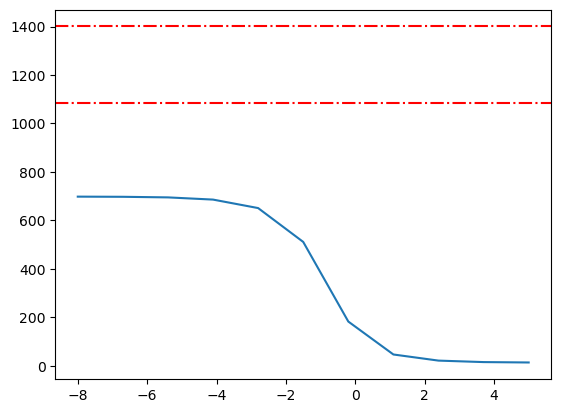

In [81]:
varb0 = (N**2)/(2*np.log(N))
varcat = ((np.pi**2-6)/6)*(N**2/np.log(N))


plt.plot(varrel['beta'], varrel['vard'])
plt.axhline(varb0, color = 'red', linestyle = '-.')
plt.axhline(varcat, color = 'red', linestyle = '-.')

In [93]:
get_pmf(1, -1)

DeviceArray([], dtype=float64)

### Level variance in the paper (feretti eq17)

In [251]:
def get_P(n, beta):
    # Probability matrix for size based beta-binom (aldous)
    P = np.zeros((n-1, n-1))
    for i in range(2, n+1):
        P[i-2, :(i-1)] = get_pmf(i, beta)

    return P

In [252]:
def simulate_splits(P):
    # this will simulate the topology and return var(d_k)'s as in the paper
    n = P.shape[0]+1       

    splits = np.zeros((n-1, 2))
    
    ret = np.zeros((n,n))
    
    l = np.arange(n)
    S = np.zeros(n)
    S[n-1] = 1
    pos_splits = np.arange(1, n)
    ret[0,:] = S    
    
    vardks = []
    avgvar = 0
    for i in l[:-1]:
        probs = S*l
        selected_lin = np.random.choice(l, 1, p = probs/probs.sum())[0]

        split = np.random.choice(pos_splits[:(selected_lin)], 1, p = P[selected_lin-1,:(selected_lin)])[0]
        k1, k2 = split, selected_lin+1-split
        S[k1-1] += 1
        S[k2-1] += 1
        S[selected_lin] = S[selected_lin] - 1
        ret[i+1, :] = S
        
        
        
        var_dk = np.var(np.repeat(l[1:], S[:-1].astype('int')))
        avgvar += var_dk/(i+1)
        vardks.append(var_dk)
        
        splits[i, :] = [k1,k2]
     
    return vardks
    #return avgvar/H(n-1)
    #return ret[1:,:-1].astype('int')

In [258]:
def sim_vard(P):
    n = P.shape[0]+1       

    splits = np.zeros((n-1, 2))
        
    l = np.arange(n)
    S = np.zeros(n)
    S[n-1] = 1
    pos_splits = np.arange(1, n)
    
    vardks = []
    avgvar = 0
    for i in l[:-1]:
        probs = S*l
        selected_lin = np.random.choice(l, 1, p = probs/probs.sum())[0]

        split = np.random.choice(pos_splits[:(selected_lin)], 1, p = P[selected_lin-1,:(selected_lin)])[0]
        k1, k2 = split, selected_lin+1-split
        S[k1-1] += 1
        S[k2-1] += 1
        S[selected_lin] = S[selected_lin] - 1
                
        var_dk = np.var(np.repeat(l[1:], S[:-1].astype('int')))
        avgvar += var_dk/(i+1)
        vardks.append(var_dk)
        splits[i, :] = [k1,k2]
     
    #return vardks
    return avgvar/H(n-1)
    #return ret[1:,:-1].astype('int')
    
def sim_bl(N):
    ts = msp.simulate(N)
    tree = ts.first()
    bls = np.array([tree.time(i) for i in tree.nodes(order = 'timedesc') if tree.is_internal(i)]+[0])
    bls = bls[:-1]-bls[1:]
    return bls

def get_ET(vard, t, a, b, g):
    n = len(t)+1
    k = np.arange(2, n+1)
    l = sum(t*k)
    
    ftl = 1 # ?
    return ftl*( a*vard + ((t/l)*(a*(n**2)/k+b*n+g*k)).sum())

In [377]:
N = 100000
an = H(N-1)

In [378]:
np.log(N)

11.512925464970229

12.090136129863433

In [384]:
N = 10000
an = H(N-1)
k = np.arange(2, N+1)

vardk0 = (N*(N-k)*(k-1))/(k*k*(k+1))

vard0 = sum(vardk0/(k-1))/np.log(N)
vard0

1573058.8229821566

In [385]:
(N**2/np.log(N))*(np.pi**2-9)/6

1573601.636799543

In [373]:
((N**2)*(np.pi**2/6-3/2))/an

19364.63773439946

In [363]:
# special variance cases

k = np.arange(2, N+1)
vardk0 = (N*(N-k)*(k-1))/(k*k*(k+1))
vard0 = sum(vardk0/(k-1))/an

vardkm2 = (k-1)*(N/k-1)**2
vardm2 = sum(vardkm2/(k-1))/an

vardinf = N/4

In [358]:
vard0

19297.89952725384

In [361]:
((2-(np.pi**2)/6)*(N**2)-N)

354065.9331517736

In [273]:
vardm2, vard0, vardinf

(1083.8235147432786, 270.37607303689896, 25.0)

In [305]:
betas = [-4, 0, 4]

sims = {}
for beta in betas:
    P = get_P(N, beta)
    sims[beta] = [sim_vard(P) for _ in range(1000)]


<ipython-input-4-a254e11a5c4d>:58: RuntimeWarning: invalid value encountered in log
  norm = jnp.where(beta>1, np.log(-2**(-2 - 2*beta)*(np.sqrt(np.pi))/(np.sin((beta+n)*np.pi)))+


In [306]:
[np.mean(sims[beta]) for beta in betas]

[1067.5467338732356, 275.1718955406585, 47.06137918193755]

In [386]:
a = -2/(N*(N-1))
b = 2/(N-1)
g = -1/an

In [281]:
# distribution of Tajima's D
ETs = []
ETsCv = []
for _ in range(1000):
    vard = sim_vard(P)
    t = sim_bl(N)
    ETs.append(get_ET(vard, t, a, b, g))
    ETsCv.append(get_ET(vard0, t, a, b, g))

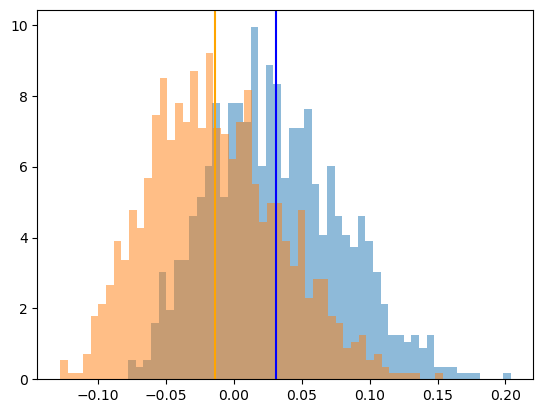

In [282]:
plt.hist(ETs, density = True, bins = 50, alpha = 0.5)
plt.axvline(np.mean(ETs), color = 'blue')

plt.hist(ETsCv, density = True, bins = 50, alpha = 0.5)
plt.axvline(np.mean(ETsCv), color = 'orange')

In [279]:
# Distributions under different betas

In [342]:
betas = np.linspace(-4, 4, 21)
nit = 2500
betas

array([-4. , -3.6, -3.2, -2.8, -2.4, -2. , -1.6, -1.2, -0.8, -0.4,  0. ,
        0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ])

In [343]:
Ds = {}
for beta in tqdm(betas):
    P = get_P(N, beta)

    Ds[beta] = [get_ET(sim_vard(P), sim_bl(N), a, b, g) for _ in range(nit)]    

<ipython-input-4-a254e11a5c4d>:58: RuntimeWarning: invalid value encountered in log
  norm = jnp.where(beta>1, np.log(-2**(-2 - 2*beta)*(np.sqrt(np.pi))/(np.sin((beta+n)*np.pi)))+


In [344]:
df = pd.DataFrame({'beta': np.round(np.repeat(betas, nit),2), 'D':np.array(list(Ds.values())).flatten()})

#### limits of above

In [345]:
Dslims = {}

In [346]:
nit = 25000
Dslims['-inf'] = [get_ET(vardm2, sim_bl(N), a, b, g) for _ in range(nit)]
Dslims['inf'] = [get_ET(vardinf, sim_bl(N), a, b, g) for _ in range(nit)]

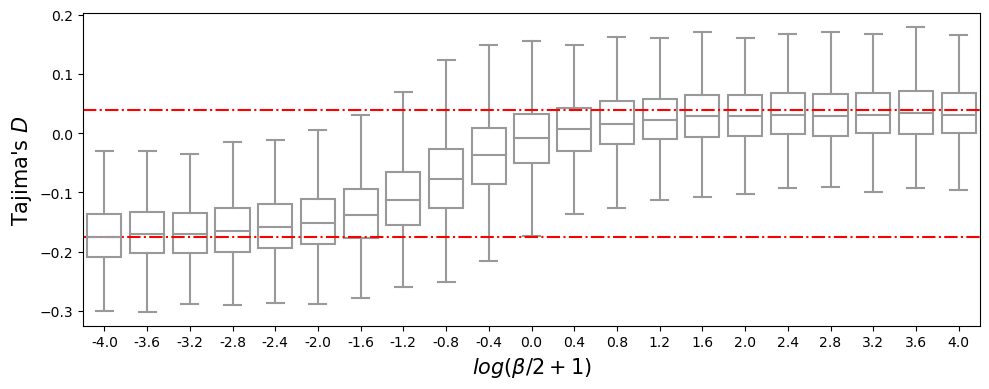

In [349]:
plt.figure(figsize = (10, 4))
sns.boxplot(data=df, x='beta', y='D', 
            showfliers=False, color = 'white')
plt.axhline(np.mean(Dslims['-inf']), color = 'red', linestyle = '-.')
plt.axhline(np.mean(Dslims['inf']), color = 'red', linestyle = '-.')
plt.xlabel(r'$log(\beta/2+1)$', size = 15)
plt.ylabel(r"Tajima's $D$",size = 15)
plt.tight_layout()
plt.savefig('plots/sampledtajd.jpg', dpi = 300)

## Fay H

In [389]:
a = -4/(N*(N-1))
b = 2/(N-1)
g = 0

In [ ]:
Hs = {}
for beta in tqdm(betas):
    P = get_P(N, beta)

    Hs[beta] = [get_ET(sim_vard(P), sim_bl(N), a, b, g) for _ in range(nit)]    

<ipython-input-4-a254e11a5c4d>:58: RuntimeWarning: invalid value encountered in log
  norm = jnp.where(beta>1, np.log(-2**(-2 - 2*beta)*(np.sqrt(np.pi))/(np.sin((beta+n)*np.pi)))+
